# Anamoly Detection in Cisco Webex data

In [1]:
import random
import luminol
import datetime
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adtk.visualization import plot
from adtk.detector import PersistAD
from adtk.detector import SeasonalAD
from adtk.data import validate_series
from adtk.detector import LevelShiftAD
from adtk.detector import OutlierDetector
from adtk.detector import VolatilityShiftAD
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from luminol.anomaly_detector import AnomalyDetector
warnings.filterwarnings('ignore')

# Method 1(Using Luminol)

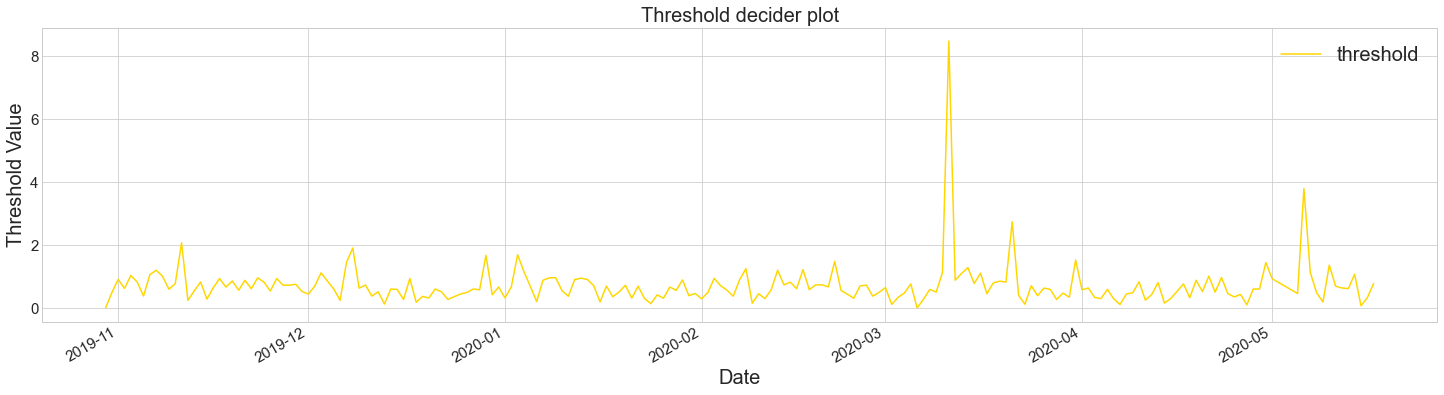

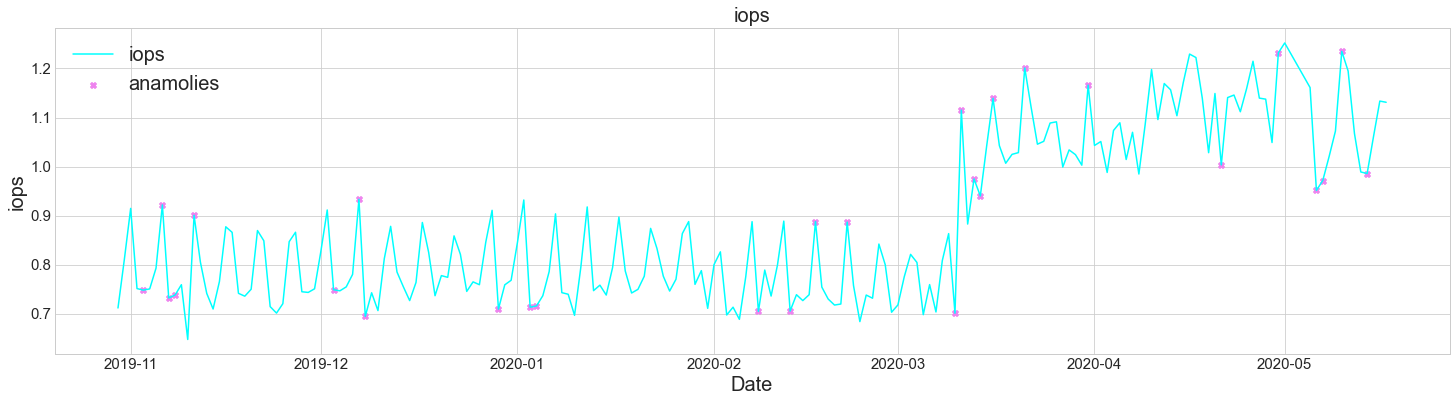

In [5]:
def preprocesData(clusterName, metric):
    df = pd.read_csv('Data/'+clusterName+'.csv')
    ts = df.copy()
    ts.drop(columns = [column for column in df.columns if column != metric and column != 'timestamps'], inplace=True)
    df['date'] = 0
    for i in range(len(df.timestamps)):
        df['date'][i] = datetime.datetime.fromtimestamp(df.timestamps[i]/1000.0).strftime('%Y-%m-%d')
    df.drop(columns = ['Unnamed: 0', 'datastore'], inplace = True)
    df['date']=pd.to_datetime(df['date'])
    df.set_index('date',inplace=True)
    df.drop(columns = [i for i in df.columns if i != metric and i != 'timestamps'], inplace = True)
    dict_ts = {}
    for i in range(len(ts)):
        dict_ts[ts['timestamps'][i]] = ts['iops'][i]
    return df, dict_ts

def luminol(ts):
    my_detector = AnomalyDetector(ts)
    score = my_detector.get_all_scores()
    return score

def plotLuminolAnomlies(df, metric, score, threshold):
    colors = ['blue', 'gold', 'red', 'magenta', 'black', 'cyan', 'violet']
    random.shuffle(colors)
    sc = []
    for _, value in score.iteritems():
        sc.append(value)
    df['score'] = sc
    df['anomaly'] = df.score > threshold
    plt.figure(figsize=(25, 6))
    df['score'].plot(color = colors[0], label = 'threshold')
    plt.xlabel('Date', fontsize = 20)
    plt.ylabel('Threshold Value', fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(fontsize = 20)
    plt.title('Threshold decider plot', fontsize = 20)
    plt.show()
    print('\n\n')
    plt.figure(figsize=(25, 6))
    plt.plot(df.index, df[metric], color = colors[1], label = metric)
    plt.scatter(df.index[df.anomaly == True], df[metric][df.anomaly == True], color = colors[2], label = 'anamolies', marker = 'X')
    plt.xlabel('Date', fontsize = 20)
    plt.ylabel(metric, fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(fontsize = 20)
    plt.title(metric, fontsize = 20)
    plt.show()
    
def predictAndPlotAnomaliesUsingLuminol(clusterName, metric):
    df, ts = preprocesData(clusterName, metric)
    score = luminol(ts)
    plotLuminolAnomlies(df, metric, score, threshold = 1)
    
predictAndPlotAnomaliesUsingLuminol('ams01-p02-c01b1', 'iops')

# Method 2(Using Isolation Forest(UnSupervised Method))

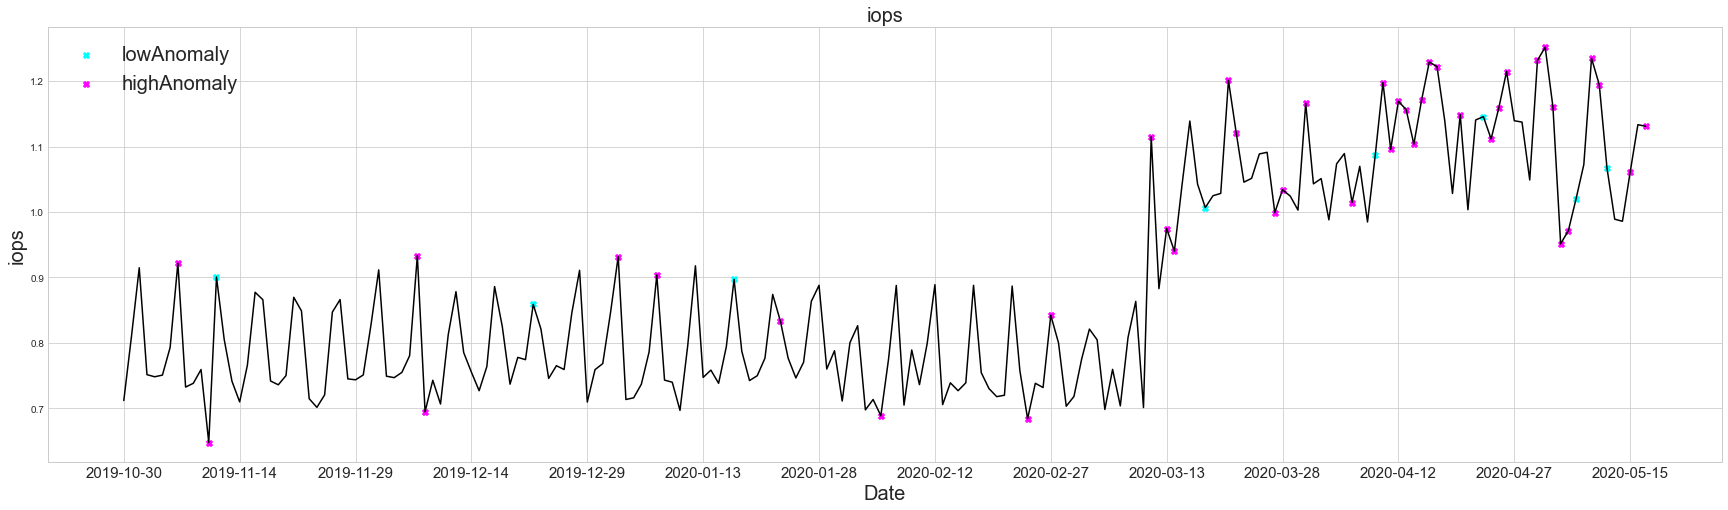

In [6]:
def createModelAndPredict(df, metric, estimators, perAnomalies=0.2):
    clf = IsolationForest(n_estimators=estimators, max_samples='auto', contamination=perAnomalies, max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
    clf.fit(np.array(df[metric]).reshape(-1, 1))
    pred = clf.predict(np.array(df[metric]).reshape(-1, 1))
    return clf, pred

def classifyAnomalies(df, metric):
    df['metric_name'] = metric
    df['anomaly'].loc[df['anomaly'] == 1] = 0
    df['anomaly'].loc[df['anomaly'] == -1] = 2
    df['anomaly_class'] = df['anomaly']
    max_anomaly_score = df['score'].loc[df['anomaly_class'] == 2].max()
    medium_percentile = df['score'].quantile(0.24)
    df['anomaly_class'].loc[(df['score'] > max_anomaly_score) & (df['score'] <= medium_percentile)] = 1
    return df

def plotForestAnomalies(df, pred, clf, metric = 'iops'):
    colors = ['blue', 'gold', 'red', 'magenta', 'black', 'cyan']
    random.shuffle(colors)
    test_df = pd.DataFrame()
    test_df['date'] = df.date
    test_df[metric] = df[metric]
    test_df['score'] = clf.decision_function(np.array(df[metric]).reshape(-1, 1))
    test_df['anomaly'] = pred
    outliers = test_df.loc[test_df['anomaly']==-1]
    outlier_index = list(outliers.index)
    test_df = classifyAnomalies(test_df, metric)
    plt.figure(figsize=(30, 8))
    plt.plot(test_df.date, test_df[metric], color = colors[0])
    plt.scatter(test_df.date[test_df.anomaly_class == 1], test_df[metric][test_df.anomaly_class == 1], label = 'lowAnomaly', color = colors[1], marker = 'X')
    plt.scatter(test_df.date[test_df.anomaly_class == 2], test_df[metric][test_df.anomaly_class == 2], label = 'highAnomaly', color = colors[2], marker = 'X')
    plt.xticks([i for i in range(len(df)) if i%15==0], fontsize = 15)
    plt.title(metric, fontsize = 20)
    plt.xlabel('Date', fontsize = 20)
    plt.ylabel(metric, fontsize = 20)
    plt.legend(fontsize = 20)
    plt.show()
    
def predictAndPlotAnomaliesUsingForest(clusterName, metric, estimators, perAnomalies):
    df = pd.read_csv('Data/'+clusterName+'.csv')
    df['date'] = 0
    for i in range(len(df.timestamps)):
        df['date'][i] = (datetime.datetime.fromtimestamp(df.timestamps[i]/1000.0).strftime('%Y-%m-%d'))
    df.drop(columns = ['Unnamed: 0', 'datastore', 'timestamps'], inplace = True)
    clf, pred = createModelAndPredict(df, metric, estimators, perAnomalies)
    plotForestAnomalies(df, pred, clf, metric)
    
predictAndPlotAnomaliesUsingForest('ams01-p02-c01b1', 'iops', 150, 0.2)

# Method 3(Using ADTK Library)

Not applicable


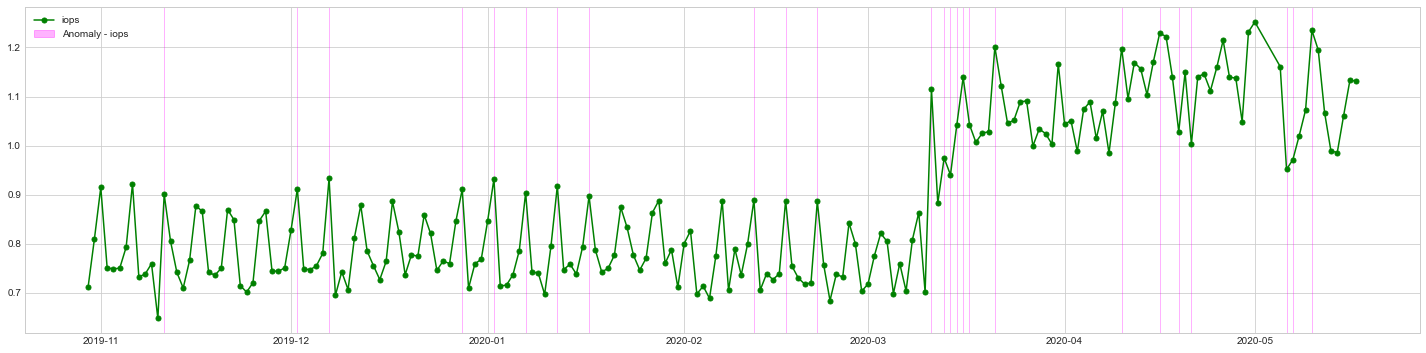

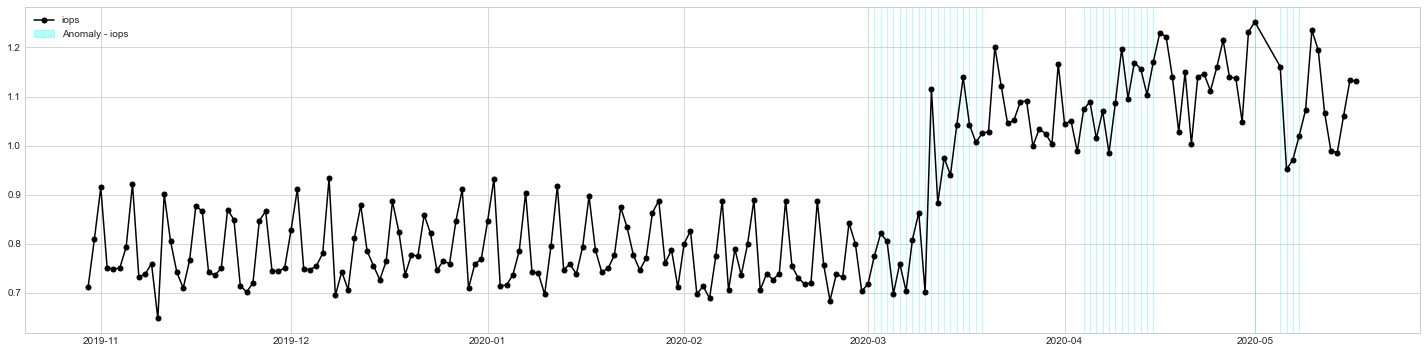

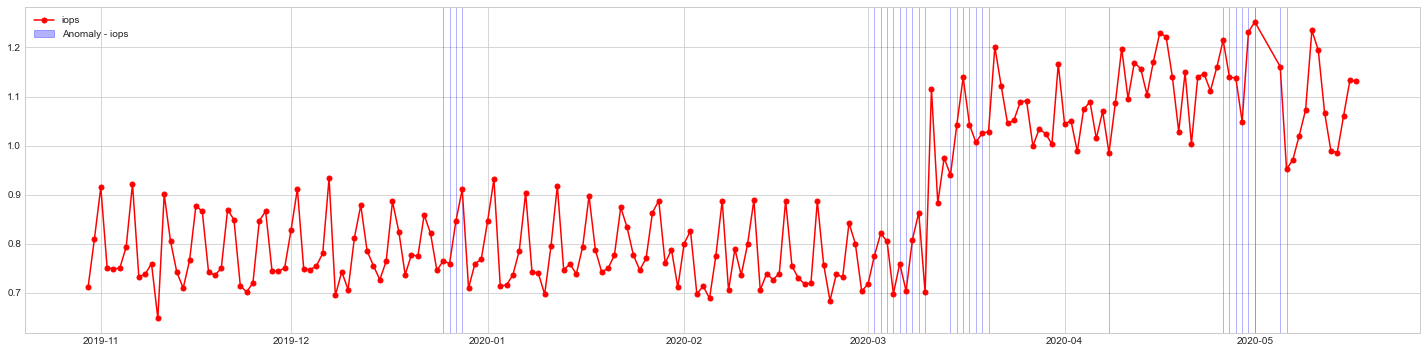

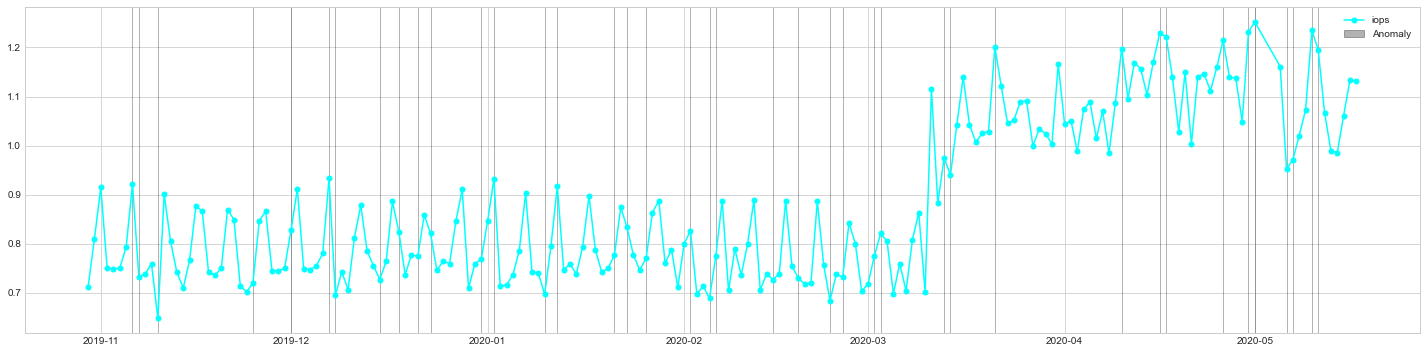

In [7]:
def detectAnomalyUsingADTK(clusterName, metric, c, side, window, contamination):
    colors = ['blue', 'green', 'red', 'magenta', 'black', 'cyan']
    random.shuffle(colors)
    df, _ = preprocesData(clusterName, metric)
    df.drop(columns = ['timestamps'], inplace = True)
    X_train = validate_series(df)
    try:
        persist_ad = PersistAD(c = c, side = side, window = window)
        anomalies = persist_ad.fit_detect(X_train)
        plot(X_train, anomaly = anomalies, anomaly_color = colors[0], ts_color = colors[-1], figsize = (25, 6),  ts_markersize = 10, ts_linewidth=1.5, anomaly_markersize=14)
    except:
        print("Not applicable")
        
    try:
        level_shift_ad = LevelShiftAD(c = c, side = side, window = window)
        anomalies = level_shift_ad.fit_detect(X_train)
        plot(X_train, anomaly = anomalies, anomaly_color = colors[1], ts_color = colors[-2], figsize = (25, 6),  ts_markersize = 10, ts_linewidth=1.5, anomaly_markersize=14)
    except:
        print("Not applicable")
    
    try:
        volatility_shift_ad = VolatilityShiftAD(c = c, side = side, window = window)
        anomalies = volatility_shift_ad.fit_detect(X_train)
        plot(X_train, anomaly = anomalies, anomaly_color = colors[2], ts_color = colors[-3], figsize = (25, 6),  ts_markersize = 10, ts_linewidth=1.5, anomaly_markersize=14)
    except:
        print("Not applicable")
        
    try:
        seasonal_ad = SeasonalAD(c = c, side = side)
        anomalies = seasonal_ad.fit_detect(X_train)
        plot(X_train, anomaly = anomalies, anomaly_color = colors[3], ts_color = colors[-4], figsize = (25, 6),  ts_markersize = 10, ts_linewidth=1.5, anomaly_markersize=14)
    except:
        print("Not applicable")
        
    try:
        outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=contamination))
        anomalies = outlier_detector.fit_detect(X_train)
        plot(X_train, anomaly = anomalies, anomaly_color = colors[4], ts_color = colors[-5], figsize = (25, 6),  ts_markersize = 10, ts_linewidth=1.5, anomaly_markersize=14)
    except:
        print("Not applicable")
        
detectAnomalyUsingADTK('ams01-p02-c01b1', 'iops', 0.5, 'both', 10, 0.2)